In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cg, minimize
import h5py
c = 2.99792458e8   # m/s

In [2]:
def doppler(v):
    frac = (1. - v/c) / (1. + v/c)
    return np.sqrt(frac)
        
def state(xs, xps, yps):
    # returns a, b such that ys = a * xs + b
    yps = np.concatenate((yps, [yps[-1]]), axis=0) # hack for end of grid
    xps = np.concatenate((xps, [xps[-1]+1.]), axis=0) # hack for end of grid
    mps = np.searchsorted(xps, xs, side='left')
    yps = np.concatenate(([yps[0]], yps), axis=0) # hack for end of grid
    xps = np.concatenate(([xps[0]-1.], xps), axis=0) # hack for end of grid
    ehs = (yps[mps+1] - yps[mps])/(xps[mps+1] - xps[mps])
    bes = yps[mps] - ehs * xps[mps]
    return ehs, bes
    
def P(ehs, bes, xs):
    return ehs * xs + bes

def dPdv(ehs, bes, v):
    dPdx = ehs
    M = len(ehs[0])
    v_tile = np.tile(v, (M,1)).T
    dxdv = doppler(v_tile) / c / (1. - v_tile/c)**2
    return dPdx * dxdv
    
def Pdot(lnlambdas, lnlambdaps, lnfluxps, v):
    try:
        N = len(v)
    except:
        N = 1
    M = len(lnlambdas)
    lnlambdas_shifted = np.tile(lnlambdas, (N,1)) + np.tile(np.log(doppler(v)), (M,1)).T # N x M
    ehs, bes = state(lnlambdas_shifted, lnlambdaps, lnfluxps)
    return P(ehs, bes, lnlambdas_shifted) # this is lnfluxs

def dotP(lnlambdas, lnlambdaps, lnfluxs):
    M = len(lnlambdas)
    Mp = len(lnlambdaps)
    ehs, bes = state(lnlambdaps, lnlambdas, lnfluxs)
    return P(ehs, bes, lnlambdaps) # this is lnfluxps

def P_state(lnlambdas, lnlambdaps, lnfluxps, v):
    try:
        N = len(v)
    except:
        N = 1
    M = len(lnlambdas)
    lnlambdas_shifted = np.tile(lnlambdas, (N,1)) + np.tile(np.log(doppler(v)), (M,1)).T # N x M
    ehs, bes = state(lnlambdas_shifted, lnlambdaps, lnfluxps)
    return ehs, bes, lnlambdas_shifted

def state_P(lnlambdas, lnlambdaps, lnfluxs):
    M = len(lnlambdas)
    Mp = len(lnlambdaps)
    ehs, bes = state(lnlambdaps, lnlambdas, lnfluxs)
    return ehs, bes, lnlambdaps

In [3]:
f = h5py.File('../data/hip54287.hdf5', 'r')

N = 75
data = np.copy(f['data'])[:N,:]
data_xs = np.log(np.copy(f['xs']))
ivars = np.copy(f['ivars'])[:N,:]
true_rvs = np.copy(f['true_rvs'])[:N]
bervs = np.copy(f['berv'])[:N] * -1.e3

for i in xrange(len(data)):
    data[i] /= np.median(data[i])
    
data = np.log(data)

In [4]:
def make_template(all_data, rvs, xs, dx):
    """
    `all_data`: `[N, M]` array of pixels
    `rvs`: `[N]` array of RVs
    `xs`: `[M]` array of wavelength values
    `dx`: linear spacing desired for template wavelength grid (A)
    """
    (N,M) = np.shape(all_data)
    all_xs = np.empty_like(all_data)
    for i in range(N):
        all_xs[i,:] = xs + np.log(doppler(rvs[i])) # shift to rest frame
    all_data, all_xs = np.ravel(all_data), np.ravel(all_xs)
    tiny = 10.
    template_xs = np.arange(min(all_xs)-tiny*dx, max(all_xs)+tiny*dx, dx)
    template_ys = np.nan + np.zeros_like(template_xs)
    for i,t in enumerate(template_xs):
        ind = (all_xs >= t-dx/2.) & (all_xs < t+dx/2.)
        if np.sum(ind) > 0:
            template_ys[i] = np.nanmedian(all_data[ind])
    ind_nan = np.isnan(template_ys)
    template_ys.flat[ind_nan] = Pdot(template_xs[ind_nan], template_xs[~ind_nan], template_ys[~ind_nan], 0.0) #np.interp(template_xs[ind_nan], template_xs[~ind_nan], template_ys[~ind_nan])
    return template_xs, template_ys

def subtract_template(data_xs, data, model_xs_t, model_ys_t, rvs_t):
    (N,M) = np.shape(data)
    data_sub = np.copy(data)
    for n,v in enumerate(rvs_t):
        model_ys_t_shifted = Pdot(data_xs, model_xs_t, model_ys_t, v)
        data_sub[n,:] -= np.ravel(model_ys_t_shifted)
        if n == 0:
            plt.plot(data_xs, data[n,:], color='k')
            plt.plot(data_xs, data_sub[n,:], color='blue')
            plt.plot(data_xs, np.ravel(model_ys_t_shifted), color='red')
    return data_sub

In [5]:
x0_star = bervs
x0_t = np.zeros(N)
model_xs_star, model_ys_star = make_template(data, x0_star, data_xs, np.log(6000.01) - np.log(6000.))
model_xs_t, model_ys_t = make_template(data, x0_t, data_xs, np.log(6000.01) - np.log(6000.))

In [ ]:
def lnlike_starmodel(model_ys_star, rvs_star, rvs_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
    ehs_star, bes_star, lnlambdas_shifted_star = P_state(data_xs, model_xs_star, model_ys_star, rvs_star)
    pd_star = P(ehs_star, bes_star, lnlambdas_shifted_star)
    ehs_t, bes_t, lnlambdas_shifted_t = P_state(data_xs, model_xs_t, model_ys_t, rvs_t)
    pd_t = P(ehs_t, bes_t, lnlambdas_shifted_t)
    pd = pd_star + pd_t
    ehs_starmodel, bes_starmodel, lnlambdaps_starmodel = state_P(data_xs, model_xs_star, model_ys_star)
    dp_star = P(ehs_starmodel, bes_starmodel, lnlambdaps_starmodel)
    ehs_tmodel, bes_tmodel, lnlambdaps_tmodel = state_P(data_xs, model_xs_t, model_ys_t)
    dp_t = P(ehs_tmodel, bes_tmodel, lnlambdaps_tmodel)
    dp = dp_star + dp_t
    lnlike = -0.5 * np.sum((data - pd)**2 * ivars)
    dlnlike_dw = 0.5 * np.sum(dp * (data - pd) * ivars, axis=0) # M' length
    return -1 * lnlike, -1 * dlnlike_dv

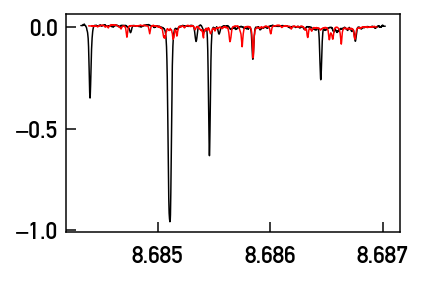

In [6]:
plt.plot(model_xs_star, model_ys_star, color='k')
plt.plot(model_xs_t, model_ys_t, color='red')

In [17]:
def rv_lnprior(rvs):
    return -0.5 * np.mean(rvs)**2/1.**2

def lnlike_star(rvs_star, rvs_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    ehs_star, bes_star, lnlambdas_shifted_star = P_state(data_xs, model_xs_star, model_ys_star, rvs_star)
    pd_star = P(ehs_star, bes_star, lnlambdas_shifted_star)
    ehs_t, bes_t, lnlambdas_shifted_t = P_state(data_xs, model_xs_t, model_ys_t, rvs_t)
    pd_t = P(ehs_t, bes_t, lnlambdas_shifted_t)
    pd = pd_star + pd_t
    dpd_dv = dPdv(ehs_star, bes_star, rvs_star)
    lnlike = -0.5 * np.sum((data - pd)**2 * ivars)
    lnpost = lnlike + rv_lnprior(rvs_star)
    dlnlike_dv = -np.sum((data - pd) * ivars * dpd_dv, axis=1)
    return -1 * lnpost, -1 * dlnlike_dv

def lnlike_t(rvs_t, rvs_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    ehs_star, bes_star, lnlambdas_shifted_star = P_state(data_xs, model_xs_star, model_ys_star, rvs_star)
    pd_star = P(ehs_star, bes_star, lnlambdas_shifted_star)
    ehs_t, bes_t, lnlambdas_shifted_t = P_state(data_xs, model_xs_t, model_ys_t, rvs_t)
    pd_t = P(ehs_t, bes_t, lnlambdas_shifted_t)
    pd = pd_star + pd_t
    dpd_dv = dPdv(ehs_t, bes_t, rvs_t)
    lnlike = -0.5 * np.sum((data - pd)**2 * ivars)
    lnpost = lnlike + rv_lnprior(rvs_t)
    dlnlike_dv = -np.sum((data - pd) * ivars * dpd_dv, axis=1)
    return -1 * lnpost, -1 * dlnlike_dv

In [21]:
stepsize = 0.1
rv_steps = np.arange(0, 10, stepsize)
lnlike = np.zeros_like(rv_steps)
dlnlike = np.zeros_like(rv_steps)
for i in xrange(len(rv_steps)):
    drv = np.zeros(N) + rv_steps[i]
    lnlike[i], dlnlike_all = lnlike_star(x0_star + drv, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
    dlnlike[i] = np.sum(dlnlike_all)
    
print lnlike[-1] + rv_lnprior(x0_star+drv) - lnlike[0] - rv_lnprior(x0_star)
print np.sum(dlnlike*stepsize)

340.124024952
343.553840776


In [8]:
soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
print np.std(soln_star - true_rvs)


         Current function value: 448037.464340
         Iterations: 31
         Function evaluations: 108
         Gradient evaluations: 96
39.0408548357


In [9]:
soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
soln_t =  minimize(lnlike_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']

x0_star = soln_star
x0_t = soln_t
print np.std(x0_star - true_rvs)
print np.std(x0_t)

         Current function value: 448037.464340
         Iterations: 31
         Function evaluations: 108
         Gradient evaluations: 96
         Current function value: 441841.682950
         Iterations: 52
         Function evaluations: 104
         Gradient evaluations: 94
39.0408548357
70.8289870356


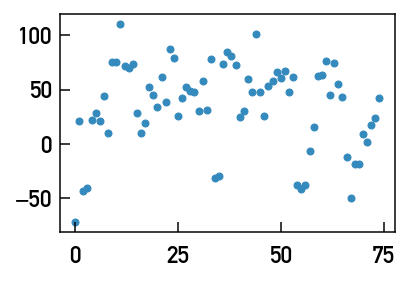

In [10]:
plt.scatter(np.arange(N), soln_star - true_rvs)

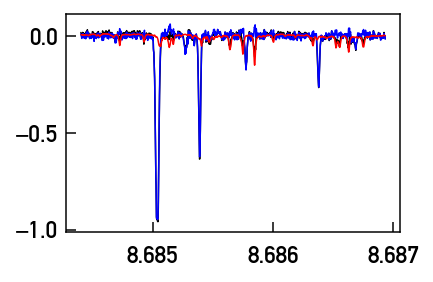

In [11]:
data_star = subtract_template(data_xs, data, model_xs_t, model_ys_t, x0_t)

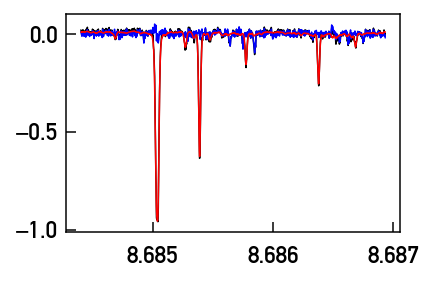

In [12]:
data_t = subtract_template(data_xs, data, model_xs_star, model_ys_star, x0_star)

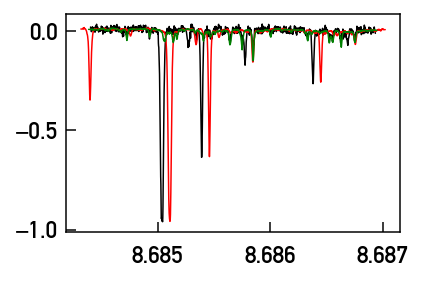

In [13]:
plt.plot(data_xs, data[0,:], color='black')
plt.plot(model_xs_star, model_ys_star, color='red')
plt.plot(model_xs_t, model_ys_t, color='green')

In [14]:
soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
soln_t =  minimize(lnlike_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']


print np.std(soln_star - true_rvs)
print np.std(soln_t)

         Current function value: 447685.015427
         Iterations: 3
         Function evaluations: 49
         Gradient evaluations: 38
         Current function value: 441840.321065
         Iterations: 30
         Function evaluations: 97
         Gradient evaluations: 87
39.1336095365
70.9499341926


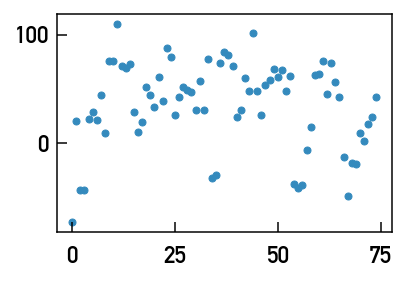

In [15]:
plt.scatter(np.arange(N), soln_star - true_rvs)

         Current function value: 982735.035018
         Iterations: 0
         Function evaluations: 18
         Gradient evaluations: 6
         Current function value: 351141.535259
         Iterations: 0
         Function evaluations: 19
         Gradient evaluations: 7
iter 0: star std = 21.28, telluric std = 70.29


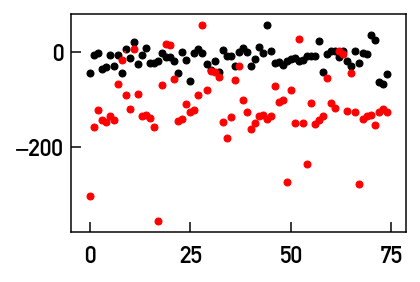

         Current function value: 1000999.029934
         Iterations: 0
         Function evaluations: 18
         Gradient evaluations: 6
         Current function value: 369405.530174
         Iterations: 0
         Function evaluations: 19
         Gradient evaluations: 7
iter 1: star std = 21.28, telluric std = 70.29


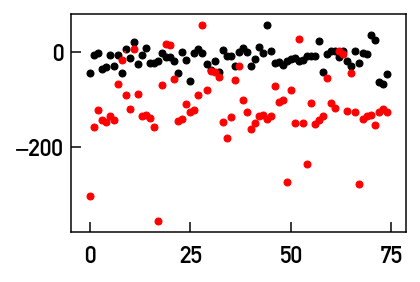

         Current function value: 979978.601766
         Iterations: 0
         Function evaluations: 18
         Gradient evaluations: 6
         Current function value: 348385.102006
         Iterations: 0
         Function evaluations: 19
         Gradient evaluations: 7
iter 2: star std = 21.28, telluric std = 70.29


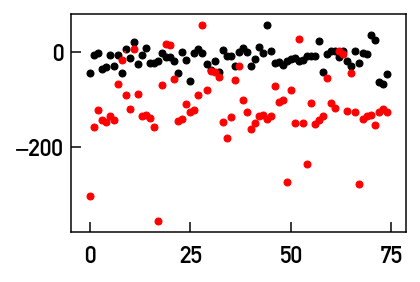

         Current function value: 997066.496729
         Iterations: 0
         Function evaluations: 18
         Gradient evaluations: 6
         Current function value: 365472.996969
         Iterations: 0
         Function evaluations: 19
         Gradient evaluations: 7
iter 3: star std = 21.28, telluric std = 70.29


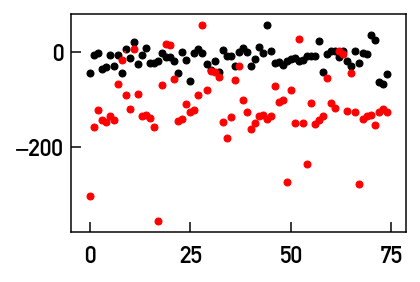

         Current function value: 977862.340446
         Iterations: 0
         Function evaluations: 18
         Gradient evaluations: 6
         Current function value: 346268.840687
         Iterations: 0
         Function evaluations: 19
         Gradient evaluations: 7
iter 4: star std = 21.28, telluric std = 70.29


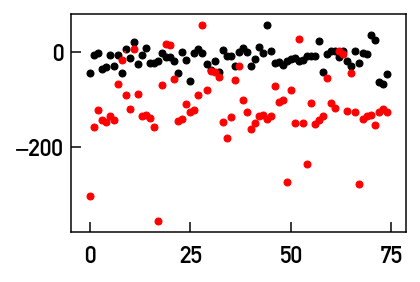

In [18]:
for n in range(5):
    x0_star = soln_star
    x0_t = soln_t

    data_star = subtract_template(data_xs, data, model_xs_t, model_ys_t, x0_t)
    data_t = subtract_template(data_xs, data, model_xs_star, model_ys_star, x0_star)

    model_xs_star, model_ys_star = make_template(data_star, x0_star, data_xs, np.log(6000.01) - np.log(6000.))
    model_xs_t, model_ys_t = make_template(data_t, x0_t, data_xs, np.log(6000.01) - np.log(6000.))

    soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
    soln_t =  minimize(lnlike_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']

    print "iter {0}: star std = {1:.2f}, telluric std = {2:.2f}".format(n, np.std(soln_star - true_rvs), np.std(soln_t))
    plt.scatter(np.arange(N), soln_star - true_rvs, color='k')
    plt.scatter(np.arange(N), soln_t, color='red')
    plt.show()


In [ ]:
plt.plot(data_xs, data[0,:], color='k')
plt.plot(data_xs, data_star[0,:] + data_t[0,:], color='red')

In [ ]:
plt.plot(data_xs, data[0,:] - data_star[0,:] - data_t[0,:])

In [ ]:
plt.hist(data[0,:] - data_star[0,:] - data_t[0,:])